In [1]:
import math 
import numpy as np
import pandas as pd
import sympy
from matplotlib import pyplot as plt
from tabulate import tabulate

In [2]:
def plot_fun(f, a, b, label="", color="r", step=0.01, ax=plt, title="Wykres funkcji"):
    n = int((b-a)/step)+1
    x = np.linspace(a,b,n)[1:]
    ax.plot(x, [f(xi) for xi in x], color=color, label=label)
    if label:
        ax.legend(loc="best")

    if ax is plt:
        ax.title(title)
        ax.xlabel("x")
        ax.ylabel("y")
    else:
        ax.set_title(title)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
    ax.grid()

In [3]:
def abs_diff(F,f, x):
    return [abs(F(xi)-float(f(xi))) for xi in x]

def max_diff(F,f, x):
    return max(abs_diff(F,f, x))

def mean_square_error(F,f, x):
    return sum(d ** 2 for d in abs_diff(F,f, x))

def calculate_error(F, f, a, b, N=1000):
    x = np.linspace(a,b,N)
    diffs = abs_diff(F,f,x)
    return {
        "max": max(diffs),
        "sq": sum(x**2 for x in diffs)
    }

def error(F, f, a, b, N=1000):
    err = calculate_error(F,f,a,b,N)
    print(tabulate([
        ("Bezwzgledny blad", err["max"]),
        ("Suma kwadratów róznic", err["sq"])
    ]))

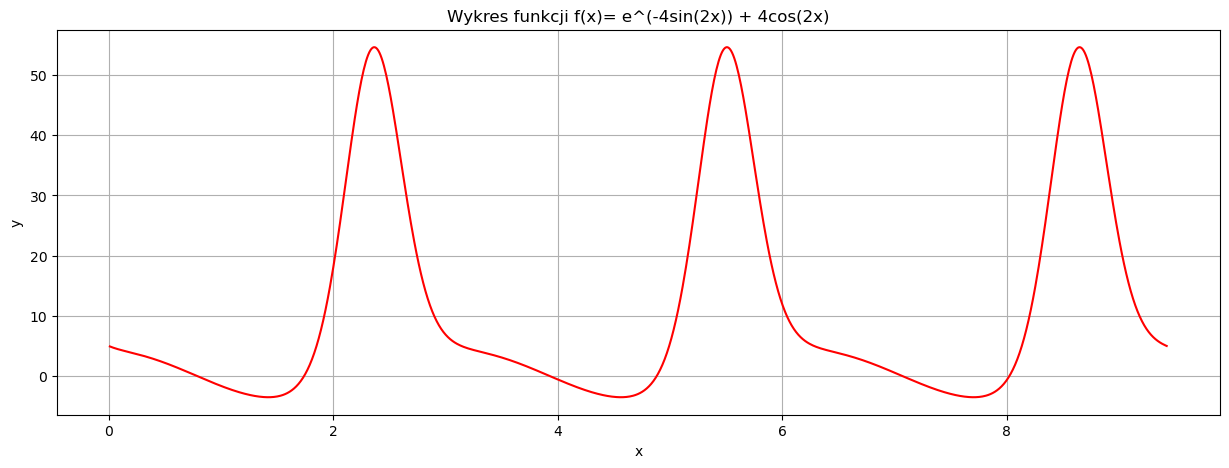

In [4]:
f = lambda x, k, m: math.e**(-k*math.sin(m*x)) + k*math.cos(m*x) 

g = lambda x: f(x, 4, 2)
a = 0
b = 3*math.pi
plt.figure(figsize=(15,5))
plot_fun(g, a, b, title="Wykres funkcji f(x)= e^(-4sin(2x)) + 4cos(2x)") 
plt.show()

In [5]:
def trigonometric_approximation(x, y, m):    
    n = len(x)
    a = x[0]
    b = x[-1]
    a_trans = -np.pi
    b_trans = np.pi
    
    def transform_x(x):
        return ((x - a) / (b - a)) * (b_trans - a_trans) + a_trans
    
    def calc_ak(k: int):
        return 2 / n * np.sum(y * np.cos(k * x))
    
    def calc_bk(k: int):
        return 2 / n * np.sum(y * np.sin(k * x))
    
    x = np.array(list(map(transform_x, x)))
    ak = np.array(list(map(calc_ak, range(m + 1))))
    bk = np.array(list(map(calc_bk, range(m + 1))))
    
    def f(x0):
        x0 = transform_x(x0)
        return .5 * ak[0] + np.sum(ak[1:] * np.cos(np.arange(1, m + 1) * x0) + bk[1:] * np.sin(np.arange(1, m + 1) * x0))
    
    return f

In [31]:
def aproximation_func(x, y, m):
    func = trigonometric_approximation(x, y, m)

    return func

def plot_aprox(n, m, show_err=False):
    x = np.linspace(a,b,n)
    y = [g(xi) for xi in x]
    w = np.ones_like(x)
    F = aproximation_func(x,y,m)

    if show_err:
        error(F, g, a,b)

    fig, ax = plt.subplots(1, figsize=(15,4))
    plot_fun(g,a,b,color="blue",ax=ax,label="funkcja bazowa")
    plot_fun(F,a,b,color="red",ax=ax, label="aproksymacja", title=f"Aproksymacja dla {n} węzłów i {m} stopni")
    ax.scatter(x,y, color="black")
    plt.show()

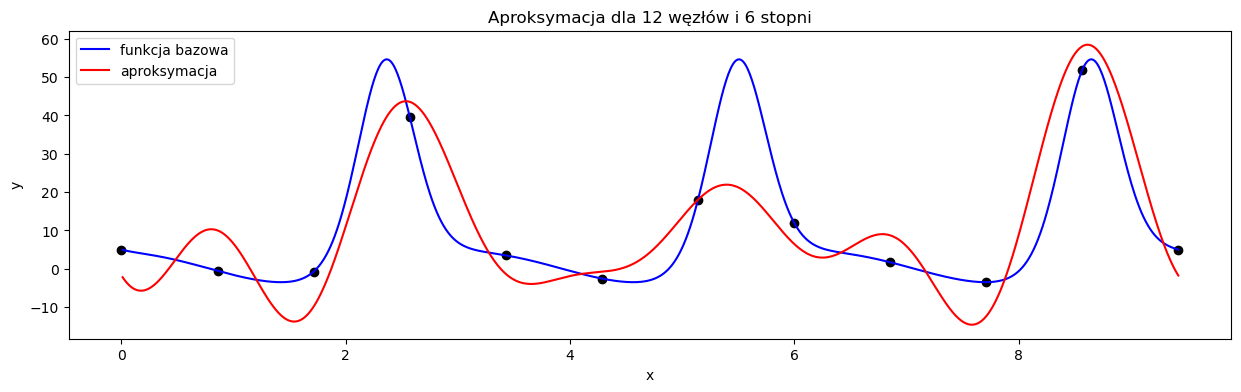

In [32]:
plot_aprox(12, 6)

In [22]:
def find_best_aprox(F, a, b, n, deg):
    abs_matirx = np.zeros((len(n), len(deg)))
    sq_matrix = np.zeros((len(n), len(deg)))

    for ni in n:
        x = np.linspace(a,b,ni)
        y = np.vectorize(F)(x)
        for m in deg:
            if m > (ni-1)//2:
                break
            f = aproximation_func(x,y,m)
            err = calculate_error(g,f,a,b)
            abs_matirx[ni-n[0], m-deg[0]] = err["max"]
            sq_matrix[ni-n[0], m-deg[0]] = err["sq"]
    return abs_matirx, sq_matrix

def find_min_error(mat):
    err = np.inf
    idx_i, idx_j = -1, -1
    for i in range(len(mat)):
        for j in range(len(mat[0])):
            if mat[i,j] != 0 and mat[i,j] < err:
                err = mat[i,j]
                idx_i, idx_j = i, j
    return err, idx_i, idx_j

In [23]:
n = range(3,200)
deg = range(3,)

ab, sq = find_best_aprox(g,a,b,n,deg)

In [34]:
df = pd.DataFrame(sq)
df = df.round(2)
df.iloc[[10,20,30,40,50,100,150,195]].loc[:, [2,3,5,10,15]]

,2,3,5,10,15
10,131449.09,105720.83,0.00,0.00,0.00
20,110138.26,28086.40,28741.19,0.00,0.00
30,109770.31,27471.21,27568.46,1556.90,0.00
40,109595.19,27204.82,27258.05,1142.25,734.11
50,109508.54,27074.53,27109.21,943.71,481.19
100,109383.44,26891.00,26899.70,662.21,130.03
150,109357.69,26855.29,26859.02,606.68,60.89
195,109348.74,26843.50,26845.61,588.10,37.81


In [35]:
df = pd.DataFrame(ab)
df = df.round(2)
df.iloc[[10,20,30,40,50,100,150,195]].loc[:, [2,3,5,10,15]]

,2,3,5,10,15
10,21.82,17.57,0.00,0.00,0.00
20,25.30,13.45,13.97,0.00,0.00
30,24.56,12.41,12.83,4.46,0.00
40,24.38,12.06,12.38,3.60,4.19
50,24.26,11.85,12.11,3.06,3.38
100,24.03,11.40,11.54,1.98,1.73
150,23.94,11.25,11.34,1.80,1.17
195,23.91,11.18,11.25,1.71,0.90


In [26]:
best_abs = find_min_error(ab)
best_sq = find_min_error(sq)
print(best_abs)
print(best_sq)

(0.8975883328747631, 196, 15)
(37.46465200839423, 196, 15)


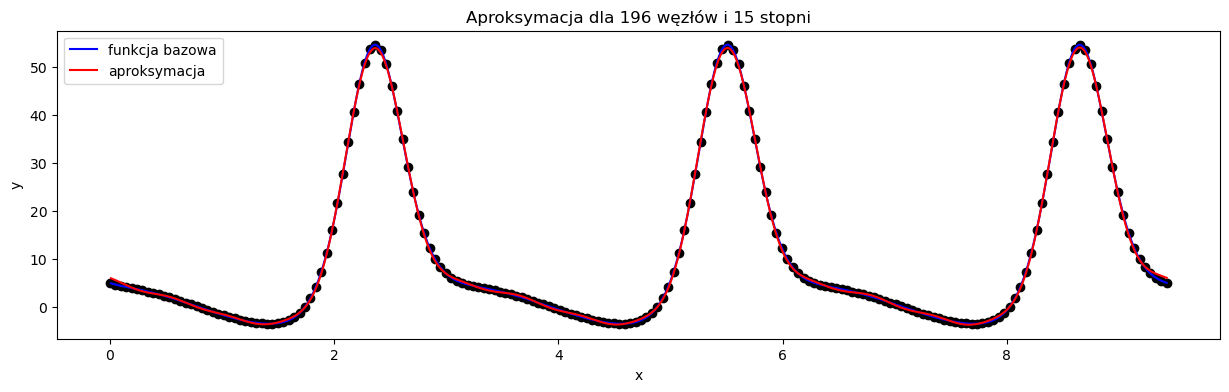

In [36]:
plot_aprox(196,15)